In [1]:
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from scipy.misc import imresize

%matplotlib inline
import pylab as pl
from IPython import display
import time

torch.cuda.set_device(3)

In [2]:
class Block(nn.Module):
    def __init__(self, insize, outsize):
        super(Block, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
            nn.BatchNorm2d(outsize),
            nn.ReLU()
        )
        
    def forward(self, inp):
        return self.layers(inp)

class ENCODER(nn.Module):
    def __init__(self):
        super(ENCODER, self).__init__()
        self.process = nn.Sequential(
            Block(3,64),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.MaxPool2d(2),
            Block(64,64)
        )
        self.rechannel = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
#             nn.Softmax2d()
        )
        self.pool = nn.AvgPool2d(10)
        
    def forward(self, inp):
        out = self.process(inp[:,:3,:,:])
#         outmask = self.LSM(self.rechannel(out).view(out.size(0),-1)).view(out.size(0),1,
#                                                                           out.size(2),out.size(2))
        return self.pool(out).squeeze(),self.rechannel(out)
    
class PREDICTOR(nn.Module):
    def __init__(self):
        super(PREDICTOR, self).__init__()
        self.sm = nn.LogSoftmax(dim=-1)
        
    def forward(self, support, inp, way):
        assert support.size(0)%way == 0,"Error: classes are not the same size!"
        support = support.view(way,support.size(0)//way,-1)
        centroids = torch.mean(support, 1).view(support.size(0),-1)
#         temp1 = torch.stack([centroids]*inp.size(0))
#         temp2 = torch.stack([inp]*centroids.size(0)).transpose(0,1)
#         print(temp1.size(),temp2.size())
        distmat = torch.sum((centroids.unsqueeze(0)-inp.unsqueeze(1))**2,2).squeeze()*-1
        probs = self.sm(distmat)
        return probs

In [3]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485,.456,.406],std=[.229,.224,.225])])
raw = torch.load('/data/imagenet/photos-annotated-0-augmented.pth')
trainset = [[[preprocess(r[1]),torch.Tensor(imresize(r[2],(10,10))).unsqueeze(0)/255] 
            for r in cat] for cat in raw]
raw = torch.load('/data/imagenet/photos-annotated-0-test.pth')
testset = [[[preprocess(r[1]),torch.Tensor(imresize(r[2],(10,10))).unsqueeze(0)/255] 
            for r in cat] for cat in raw]
del raw

In [4]:
def batchmaker(way,trainshot,testshot,theset,alterful=False):
    classes = np.random.choice(len(theset),way,replace=False)
    li = [[[theset[cl][i][0].view(1,3,84,84),theset[cl][i][1].view(1,10,10)] for i in 
           np.random.choice(len(theset[cl]),trainshot+testshot,replace=False)]
          for cl in classes]
    support = torch.cat([torch.cat([p[0] for p in t[:trainshot]],dim=0) for t in li],dim=0)
    smask = torch.cat([torch.cat([p[1] for p in t[:trainshot]],dim=0) for t in li],dim=0)
    stargs = torch.LongTensor([i//trainshot for i in range(trainshot*way)])
    query = torch.cat([torch.cat([p[0] for p in t[trainshot:]],dim=0) for t in li],dim=0)
    qmask = torch.cat([torch.cat([p[1] for p in t[trainshot:]],dim=0) for t in li],dim=0)
    qtargs = torch.LongTensor([i//testshot for i in range(testshot*way)])
#     print(support.size(),query.size())
    return(Variable(support, volatile=(not alterful)).cuda(),
           Variable(smask, requires_grad=False, volatile=(not alterful)).cuda(),
           Variable(stargs, volatile=(not alterful)).cuda(),
           Variable(query, volatile=(not alterful)).cuda(),
           Variable(qmask, requires_grad=False, volatile=(not alterful)).cuda(),
           Variable(qtargs, volatile=(not alterful)).cuda()
          )

def evaluate(embed,model,criterion,way,trainshot,testshot,reps,theset):
    masktracker = 0
    losstracker = 0
    acctracker = 0
    acclist = []
    for i in range(reps):
        s,_,_,q,qmask,qt = batchmaker(way,trainshot,testshot,theset)
        embeds,_ = embed(s)
        qembeds,mpreds = embed(q)
        preds = model(embeds,qembeds,way)
        
        # Val loss
        loss = criterion(preds,qt)
        losstracker += loss.data[0]
        maskloss = mcriterion(mpreds,qmask.unsqueeze(1))
        masktracker += maskloss.data[0]
        
        # Val accuracy
        _,bins = torch.max(preds,1)
        acc = torch.sum(torch.eq(bins,qt)).data[0]/testshot/way
        acctracker += acc
        acclist.append(acc)
    return losstracker/reps,acctracker/reps,masktracker/reps

way = 20
evalway = 5
trainshot = 5
testshot = 15
reps = 100

In [5]:
embed = ENCODER().cuda()
model = PREDICTOR().cuda()
losstracker,mlosstracker,evallosstracker,evalmlosstracker,evalacctracker = [],[],[],[],[]
optimizer = None
nweights = sum([i.numel() for i in list(embed.parameters())])
print(nweights," parameters in neural net.")

113665  parameters in neural net.


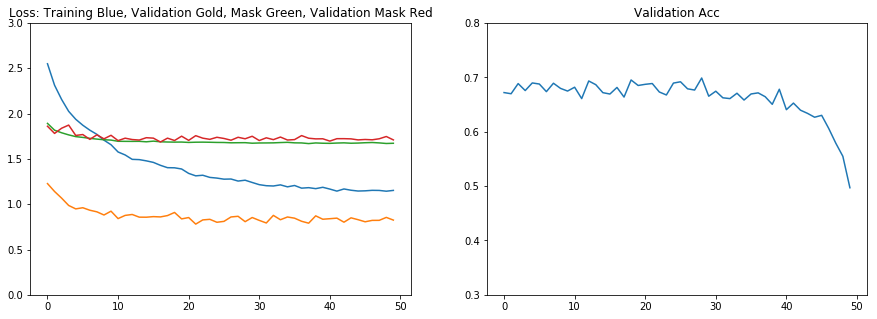

Train loss is: 1.1522433796525002
Mask BCE loss is: 0.5574965393543243

Validation accuracy is: 0.6719999999999999
Validation loss is: 0.8246127066016197
Validation mask loss is: 0.5698776984214783

1352.310647726059


In [6]:
# TRAIN!
criterion = nn.NLLLoss()
mcriterion = nn.BCEWithLogitsLoss()
vbity = 200
epoch = 2000
start = time.time()
factor = 3

runningloss = 0
runningmloss = 0
for it in range(5*epoch):
    if it%10==0:
        print(it)
    
    # Build batch
    support, _, _, query, qmask, targs = batchmaker(way,trainshot,testshot,trainset,alterful=True)
    
    # Predict
    embed.zero_grad()
    model.zero_grad()
    embeds,_ = embed(support)
    qembeds,mpreds = embed(query)
    preds = model(embeds,qembeds,way)

    # Calculate Loss
    loss = criterion(preds, targs)
    runningloss += loss.data[0]
    mloss = mcriterion(mpreds.squeeze(), qmask)
    runningmloss += mloss.data[0]*factor
    
    # Backprop
    if it%epoch == 0:
        optimizer = optim.Adam(embed.parameters(),lr=.001/(2**(it//epoch)))
    totalloss = (7*loss+mloss)/8
    totalloss.backward()
#     nn.utils.clip_grad_norm(model.parameters(), 1)
    optimizer.step()
    
    # Report
    if it%vbity == vbity-1:
        display.clear_output(wait=True)

        losstracker.append(runningloss/vbity)
        mlosstracker.append(runningmloss/vbity)
        embed = embed.eval()
        evalloss, evalacc, evalmloss = evaluate(embed,model,criterion,evalway,trainshot,testshot,
                                                reps,testset)
        embed = embed.train()
        evallosstracker.append(evalloss)
        evalmlosstracker.append(evalmloss*factor)
        evalacctracker.append(evalacc)
        
        pl.figure(1,figsize=(15,5))
        pl.subplot(1,2,1)
        pl.plot(losstracker)
        pl.plot(evallosstracker)
        pl.plot(mlosstracker)
        pl.plot(evalmlosstracker)
        pl.ylim((0,3))
        pl.title("Loss: Training Blue, Validation Gold, Mask Green, Validation Mask Red")
        pl.subplot(1,2,2)
        pl.plot(evalacctracker[::-1])
        pl.ylim((0.3,.8))
        pl.title("Validation Acc")
        pl.show()
        
        print("Train loss is: "+str(runningloss/vbity)+
              "\nMask BCE loss is: "+str(runningmloss/vbity/factor)+
              "\n\nValidation accuracy is: "+str(evalacc)+
              "\nValidation loss is: "+str(evalloss)+
              "\nValidation mask loss is: "+str(evalmloss)+"\n")
        runningloss = 0
        runningmloss = 0
        print(time.time()-start)

# MORE RECENT TEST
        

In [7]:
criterion = nn.NLLLoss().cuda()
embed = embed.eval()
print(evaluate(embed,model,criterion,evalway,trainshot,testshot,10000,testset))
embed = embed.train()

(0.8292620187640191, 0.6790840000000864, 0.5740871588915587)


In [ ]:
# 7/8: (0.8292620187640191, 0.6790840000000864, 0.5740871588915587)
# 3/4: (0.831196191807588, 0.6814222222222217, 0.5689244625965754)
# 1/2: (0.8258209906160832, 0.6804693333334201, 0.5561512237131596)
# 1/4: (0.8278600487276911, 0.6792573333334191, 0.5518560484021902)

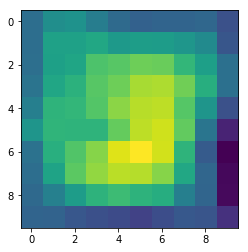

In [50]:
from matplotlib.pyplot import imshow
x = 64
imshow(mpreds[x][0].data.cpu().numpy())

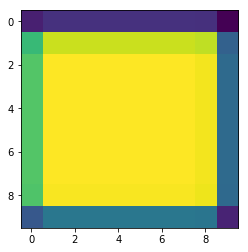

In [51]:
imshow(qmask[x].data.cpu().numpy())

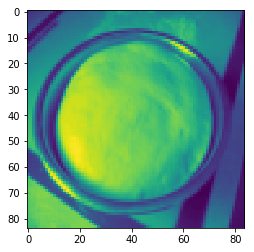

In [52]:
imshow(torch.sum(query[x],dim=0).data.cpu().numpy())


In [10]:
1.96*np.sqrt(.0090525/200)

0.01318637251104336

In [41]:
np.mean(evalacctracker[-50:])

0.5500666666666667

In [19]:
name = 'naive_full'
torch.save((embed,model,losstracker,evallosstracker,evalacctracker),'saved_models/'+name+'.pth')
torch.save(embed.cpu().state_dict(),'saved_models/'+name+'_cpu.pth')

/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type ENCODER. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type PREDICTOR. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [16]:
embed,model,losstracker,evallosstracker,evalacctracker = torch.load('saved_models/naive_4.pth')

In [ ]:
Paper model achieves (over last 1000):
    0.71156711111111126
after 188500 iters

In [213]:
support = supportmaker(nclass,shot)
inp = inpmaker(nclass)
embeds = embed(support)
query = embed(inp)
model(embeds,query)

Variable containing:
-6.7075e-03 -5.0079e+00 -2.7911e+01
-2.9057e+00 -5.6263e-02 -4.5704e+01
-1.8272e+01 -4.3870e+01 -1.1600e-08
[torch.FloatTensor of size 3x3]